<a href="https://colab.research.google.com/github/Yogita127/Project-1/blob/main/compltedskincancer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pathlib
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import PIL

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping

from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.models import load_model

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
data_dir_train = pathlib.Path("/content/drive/MyDrive/data/train")
data_dir_test = pathlib.Path("/content/drive/MyDrive/data/test")

In [ ]:
# Count the number of image in Train and Test directory
# Using the glob to retrieve files/pathnames matching a specified pattern.

#Train Image count
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)

#Test Image count
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2647
610


Found 2647 files belonging to 2 classes.


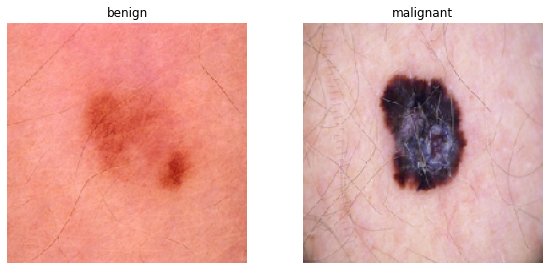

In [ ]:
#Visualize one instance of all the class present in the dataset.

#image_dataset_from_directory() will return a tf.data.Dataset that yields batches of images from the subdirectories.
#label_mode is categorial, the labels are a float32 tensor of shape (batch_size, num_classes), representing a one-hot encoding of the class index.
image_dataset = tf.keras.preprocessing.image_dataset_from_directory(data_dir_train,
                                                                    batch_size=32,
                                                                    image_size=(180,180),
                                                                    label_mode='categorical',
                                                                    seed=123)

#all the classes of Skin Cancer
class_names = image_dataset.class_names

#Dictionary to store the path of image as per the class
files_path_dict = {}

for c in class_names:
    files_path_dict[c] = list(map(lambda x:str(data_dir_train)+'/'+c+'/'+x,
                                  os.listdir(str(data_dir_train)+'/'+c)))

#Visualize image
plt.figure(figsize=(15,15))
index = 0
for c in class_names:
    path_list = files_path_dict[c][:1]
    index += 1
    plt.subplot(3,3,index)
    plt.imshow(load_img(path_list[0],target_size=(180,180)))
    plt.title(c)
    plt.axis("off")

In [ ]:
def class_distribution_count(directory):

    #count number of image in each classes
    count= []
    for path in pathlib.Path(directory).iterdir():
        if path.is_dir():
            count.append(len([name for name in os.listdir(path)
                               if os.path.isfile(os.path.join(path, name))]))

    #name of the classes
    sub_directory = [name for name in os.listdir(directory)
                    if os.path.isdir(os.path.join(directory, name))]

    #return dataframe with image count and class.
    return pd.DataFrame(list(zip(sub_directory,count)),
                        columns =['Class', 'No. of Image'])

df = class_distribution_count(data_dir_train)
df

,Class,No. of Image
0,malignant,1207
1,benign,1440


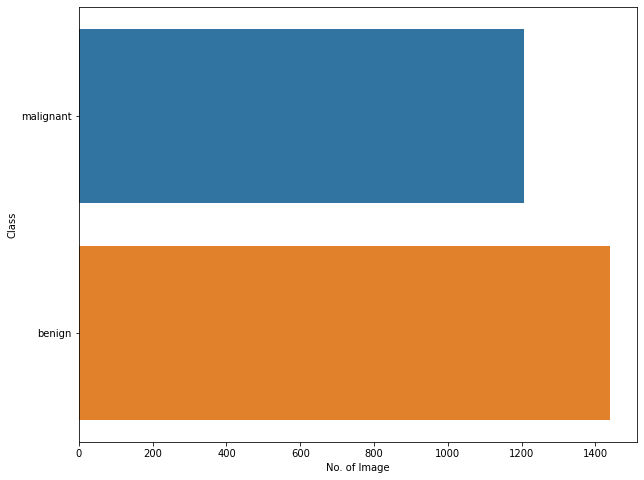

In [ ]:
#Visualize the Number of image in each class.
import seaborn as sns
plt.figure(figsize=(10, 8))
sns.barplot(x="No. of Image", y="Class", data=df,
            label="Class")

In [ ]:
#install Augmentor
!pip install Augmentor

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
#Count total number of image generated by Augmentor.
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

0


In [ ]:
# train dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(data_dir_train,
                                                               batch_size=32,
                                                               image_size=(180,180),
                                                               label_mode='categorical',
                                                               seed=123,
                                                               subset="training",
                                                               validation_split=0.2)

#label_mode is categorial, the labels are a float32 tensor of shape (batch_size, num_classes),
#representing a one-hot encoding of the class index.

Found 2647 files belonging to 2 classes.
Using 2118 files for training.


In [ ]:
# validation dataset
val_ds =tf.keras.preprocessing.image_dataset_from_directory(data_dir_train,
                                                            batch_size=32,
                                                            image_size=(180,180),
                                                            label_mode='categorical',
                                                            seed=123,subset="validation",
                                                            validation_split=0.2)

Found 2647 files belonging to 2 classes.
Using 529 files for validation.


In [ ]:
#tf.data.experimental.AUTOTUNE defines appropriate number of processes that are free for working.

#`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

#`Dataset.prefetch()` overlaps data preprocessing and model execution while training.


AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [ ]:
#CNN Model Architecture

#Sequential allows you to create models layer-by-layer
model = Sequential()

model.add(layers.experimental.preprocessing.Rescaling(1./255,
                                                      input_shape=(180,180,3)))   #Rescaling Layer

#First Convulation layer
model.add(layers.Conv2D(32,kernel_size=(3,3),activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))

#Second Convulation Layer
model.add(layers.Conv2D(64,kernel_size=(3,3),activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))

#Third Convulation Layer
model.add(layers.Conv2D(128,kernel_size=(3,3),activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))

#Dropout layer with 50% Fraction of the input units to drop.
model.add(layers.Dropout(0.5))

#Flatten Layer
##Keras.layers.flatten function flattens the multi-dimensional input tensors into a single dimension.
model.add(layers.Flatten())

#Dense Layer
model.add(layers.Dense(128,activation='relu'))

#Dropout layer with 25% Fraction of the input units to drop.
model.add(layers.Dropout(0.25))

#Dense Layer with softmax activation function.
#Softmax is an activation function that scales numbers/logits into probabilities.
model.add(layers.Dense(len(class_names),activation='softmax'))

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_2 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_6 (Conv2D)           (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 89, 89, 32)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 87, 87, 64)        18496     
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 43, 43, 64)       0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 41, 41, 128)      

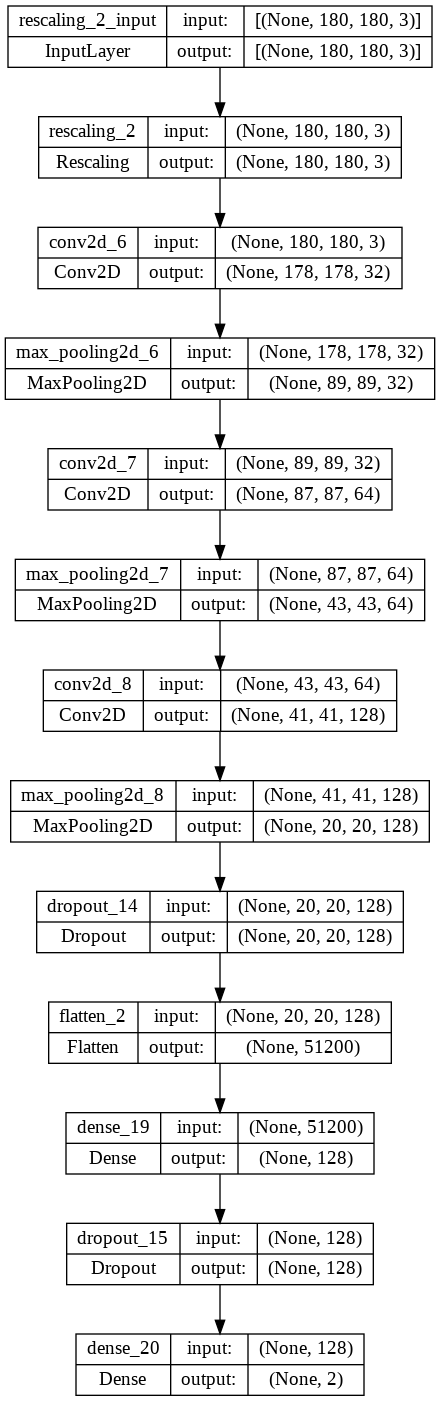

In [ ]:
# vizualizing the model
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='model_plot.png', show_shapes=True,
           show_layer_names=True)

In [ ]:
#Compile the Model

#Adam optimization: is a stochastic gradient descent method that is based on adaptive estimation of first-order and second-order moments.
#categorical_crossentropy: Used as a loss function for multi-class classification model where there are two or more output labels.

model.compile(optimizer="Adam",loss="categorical_crossentropy",
              metrics=["accuracy"])

#ModelCheckpoint callback is used in conjunction with training using model.fit() to save a model or weights (in a checkpoint file) at some interval,
#so the model or weights can be loaded later to continue the training from the state saved.
checkpoint = ModelCheckpoint("model.h5",monitor="val_accuracy",
                             save_best_only=True,mode="auto",verbose=1)

#Stop training when a monitored metric has stopped improving.
earlystop = EarlyStopping(monitor="val_accuracy", patience=9,
                          mode="auto",verbose=1)

In [ ]:
# Train the model
epochs = 30
history = model.fit(train_ds, steps_per_epoch=3 ,
                    validation_data=val_ds, epochs=epochs,
                    callbacks=[checkpoint,earlystop])

Epoch 1/30
3/3 [==============================] - ETA: 0s - loss: 3.6434 - accuracy: 0.5417
Epoch 1: val_accuracy improved from -inf to 0.44802, saving model to model.h5
3/3 [==============================] - 232s 23s/step - loss: 3.6434 - accuracy: 0.5417 - val_loss: 1.2180 - val_accuracy: 0.4480
Epoch 2/30
3/3 [==============================] - ETA: 0s - loss: 1.0020 - accuracy: 0.4792
Epoch 2: val_accuracy did not improve from 0.44802
3/3 [==============================] - 9s 4s/step - loss: 1.0020 - accuracy: 0.4792 - val_loss: 0.7016 - val_accuracy: 0.4480
Epoch 3/30
3/3 [==============================] - ETA: 0s - loss: 0.6948 - accuracy: 0.4896
Epoch 3: val_accuracy improved from 0.44802 to 0.49527, saving model to model.h5
3/3 [==============================] - 9s 4s/step - loss: 0.6948 - accuracy: 0.4896 - val_loss: 0.6919 - val_accuracy: 0.4953
Epoch 4/30
3/3 [==============================] - ETA: 0s - loss: 0.6937 - accuracy: 0.5104
Epoch 4: val_accuracy improved from 0.495


Epoch 23: val_accuracy did not improve from 0.73346
3/3 [==============================] - 8s 3s/step - loss: 0.5588 - accuracy: 0.7812 - val_loss: 0.6131 - val_accuracy: 0.7259


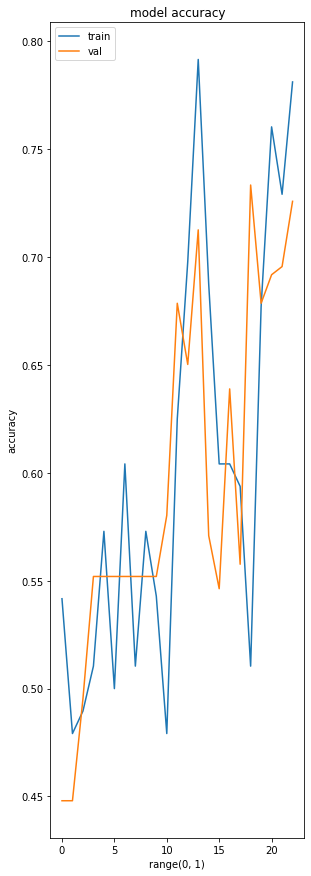

In [ ]:
# Plot the training curves

epochs_range = range(earlystop.stopped_epoch+1)

plt.figure(figsize=(10, 15))
plt.subplot(1, 2, 2)

#Plot Model Accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel(epochs_range)
plt.legend(['train', 'val'], loc='upper left')

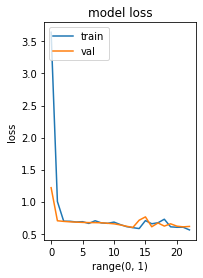

In [ ]:
#Plot Model Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel(epochs_range)
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
md = load_model("/content/model.h5")
acc = md.evaluate(val_ds)[1]
print(acc*100)

17/17 [==============================] - 6s 325ms/step - loss: 0.6183 - accuracy: 0.7335
73.34593534469604


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

trainAug  = ImageDataGenerator(
featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)

In [ ]:
#MobileNetV2 model
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2
from tensorflow.keras import Model, layers
from numpy import loadtxt

conv_base = MobileNetV2(
    include_top=False,
    input_shape=(224, 224, 3),
    weights='imagenet')

for layer in conv_base.layers:
    layer.trainable = True

In [ ]:
x = conv_base.output
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(256, activation='relu')(x)
x = layers.Dropout(0.2)(x)
x = layers.Dense(64, activation='relu')(x)
x = layers.Dropout(0.1)(x)
predictions = layers.Dense(3, activation='softmax')(x)
model = Model(conv_base.input, predictions)

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau


mc = ModelCheckpoint('.mdl_wts.hdf5', monitor='val_loss',
                             mode='min',verbose=1, save_best_only=True),

rl = ReduceLROnPlateau(monitor='val_loss', factor=0.3,
                               patience=2, verbose=1, mode='min',
                               min_lr=0.00000000001)
cb= [mc, rl]

In [ ]:
model.compile(loss='categorical_crossentropy', optimizer='adam',
              metrics=['accuracy'])
BS = 64
print("[INFO] training head...")

#epochs = 30
#H = model.fit(train_ds, steps_per_epoch=3 ,
#                    validation_data=val_ds, epochs=epochs,
#                    callbacks= cb)
H = model.fit(train_ds, steps_per_epoch=3, validation_data=val_ds,
              epochs=30, callbacks= cb)

[INFO] training head...
Epoch 1/30


ValueError: ignored

1/1 [==============================] - 0s 95ms/step
predictive class malignant


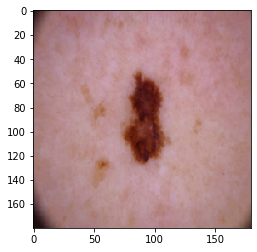

In [ ]:
from glob import glob
Test_image_path = "/content/drive/MyDrive/data/train/malignant/1052.jpg"
Test_image = glob(Test_image_path)
Test_image = load_img(Test_image[-1],target_size=(180,180,3))
plt.imshow(Test_image)
plt.grid(False)

img = np.expand_dims(Test_image,axis=0)
pred = md.predict(img)
pred = np.argmax(pred)
pred_class = class_names[pred]
#print("Actual Class + class_names[1] +'\n'+" "Predictive Class "+pred_class )
print("predictive class " + pred_class)